In [2]:
if (!require(survRM2)) install.packages('survRM2')
library('survRM2') 
if (!require(mvtnorm)) install.packages('mvtnorm')
library('mvtnorm')
if (!require(survival)) install.packages('survival')
library('survival')
if (!require(nph)) install.packages('nph')
library('nph')
if (!require(foreach)) install.packages("foreach")
library('foreach') 
if (!require(doParallel)) install.packages("doParallel")
library('doParallel')
if (!require(ggplot2)) install.packages("ggplot2")
library('ggplot2')
if (!require(cowplot)) install.packages("cowplot")
library('cowplot')
library('simtrial')  # need to be installed from Github

n_cores <- detectCores()
cluster <- makeCluster(16) # How many cores we use
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster,
  {
  library("survRM2")
  library("mvtnorm")
  library("survival")
  library("nph")
  library("simtrial")
  library("foreach")
  }))

source('/home/r27user6/RMST_Code/Function.R')
clusterExport(cluster, "expo_gen_2stages")


## 1. Late Difference
### <span style="color:yellow">with a hazard ratio of 1 until 10 months and then a hazard ratio of 0.5 onward.
#### According to Eaton 2020 (https://doi.org/10.1177/1740774520905563) simulations 
#### <span style="color:yellow"> All test in this paper are 2 sided test



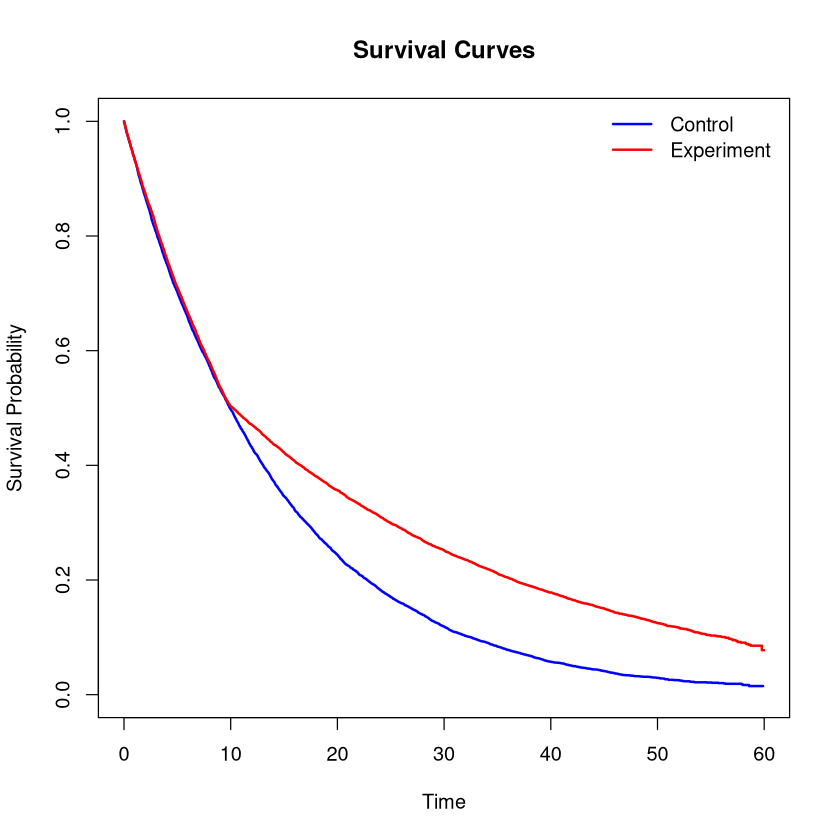

In [ ]:
median_con <- 10 # month
lambda_H0 <- log(2)/median_con
HR1 <- 1
HR2 <- 0.5
sim_size <- 10000 
acc_time <- 24
cen_time <- 36
n <- 100  # Fix total sample size
interim <- 0
change_time <- 10
set.seed(2024)

data_C3 <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', cen_time = cen_time,
                          arm = 0, interim = interim)
data_E3 <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, dist = 'pcw_exp', cen_time = cen_time,
                          HR1 = HR1, HR2 = HR2, change_time = change_time, arm = 1, interim = interim)
pre_data3 <- rbind(data_C3[ , c(4,5,1)], data_E3[ , c(4,5,1)])

fit <- survfit(Surv(pre_data3[,1], pre_data3[,2]) ~ pre_data3[,3])
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

### Scenario3 one stage log rank test and RMST (interim = 0)
### <span style="color:yellow"> In the paper, P288 table1 logrank power 0.538, RMST power 0.458

In [ ]:
data_C3 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', cen_time = cen_time,
                            arm = 0, interim = 0)[ , c(4,5,1)]

data_E3 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'pcw_exp', cen_time = cen_time,
                            HR1 = HR1, HR2 = HR2, change_time = change_time, arm = 1, interim = 0)[ , c(4,5,1)]
                          
power_lr <- log_rank_sim(data_C = data_C3, data_E = data_E3, sim_size = sim_size,
                        n = 100, alpha = 0.05, sided = 'two_sided')
cat('The power of two-sided log rank test here is:', power_lr)
RMST_two_sided_test(n = 100, data_E = data_C3, data_C = data_E3, tau = 48, sim_size = sim_size, alpha = 0.05)

The power of two-sided log rank test here is: 0.5347

,Rejection,tau.adjustment
,<dbl>,<dbl>
result.10000,0.4759,0.0119
